In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightning import pytorch as pl
from sklearn.model_selection import train_test_split
import torch
torch.set_float32_matmul_precision('medium')
from chemprop import data, featurizers, models, nn
pl.seed_everything(1)
from utils import *
# from data_utils import data_prep, prep_data, load_data, split_data, preprocess_data, create_data_loaders, create_mpnn_model
%load_ext autoreload
%autoreload 2

Seed set to 1
Seed set to 1


In [2]:
input_path = r'C:\Users\rhys-\OneDrive\Documents\Github\chemprop\notebooks\big_data\data\ir_dataset_minmax_scaled.parquet' # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = "smiles" # name of the column containing SMILES strings
target_columns = np.arange(400,4002,2).astype(str) # list of names of the columns containing targets

df_input = pd.read_parquet(input_path)

In [3]:
nist_test_path = r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\data\nist\nist_test.parquet"

nist_test_df = pd.read_parquet(nist_test_path)

test_datapoints = get_mol_datapoints(nist_test_df, smiles_column, target_columns)

test_dset = data.MoleculeDataset(test_datapoints, featurizers.SimpleMoleculeMolGraphFeaturizer())

test_loader = data.MolGraphDataLoader(test_dset, num_workers=num_workers)

In [4]:
datapoints = get_mol_datapoints(df_input, smiles_column, target_columns)

train_idx, val_idx, test_idx = data.splitting.split_data(
    datapoints,
    num_folds=8,
    split='cv',
)

train_1 = [datapoints[i] for i in train_idx[0]]
val_1 = [datapoints[i] for i in val_idx[0]]
test_1 = [datapoints[i] for i in test_idx[0]]

train_2 = [datapoints[i] for i in train_idx[1]]
val_2 = [datapoints[i] for i in val_idx[1]]
test_2 = [datapoints[i] for i in test_idx[1]]

train_3 = [datapoints[i] for i in train_idx[2]]
val_3 = [datapoints[i] for i in val_idx[2]]
test_3 = [datapoints[i] for i in test_idx[2]]

train_4 = [datapoints[i] for i in train_idx[3]]
val_4 = [datapoints[i] for i in val_idx[3]]
test_4 = [datapoints[i] for i in test_idx[3]]

train_5 = [datapoints[i] for i in train_idx[4]]
val_5 = [datapoints[i] for i in val_idx[4]]
test_5 = [datapoints[i] for i in test_idx[4]]

train_6 = [datapoints[i] for i in train_idx[5]]
val_6 = [datapoints[i] for i in val_idx[5]]
test_6= [datapoints[i] for i in test_idx[5]]

train_7 = [datapoints[i] for i in train_idx[6]]
val_7 = [datapoints[i] for i in val_idx[6]]
test_7 = [datapoints[i] for i in test_idx[6]]

train_8 = [datapoints[i] for i in train_idx[7]]
val_8 = [datapoints[i] for i in val_idx[7]]
test_8 = [datapoints[i] for i in test_idx[7]]

def create_data_loaders(train_data, val_data, test_data, num_workers=0):
    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

    train_dset = data.MoleculeDataset(train_data, featurizer)
    val_dset = data.MoleculeDataset(val_data, featurizer)
    test_dset = data.MoleculeDataset(test_data, featurizer)

    train_loader = data.MolGraphDataLoader(train_dset, batch_size=128, num_workers=num_workers)
    val_loader = data.MolGraphDataLoader(val_dset, batch_size=128, num_workers=num_workers, shuffle=False)
    test_loader = data.MolGraphDataLoader(test_dset, batch_size=128, num_workers=num_workers, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader_1, val_loader_1, test_loader_1 = create_data_loaders(train_1, val_1, test_1, num_workers)
train_loader_2, val_loader_2, test_loader_2 = create_data_loaders(train_2, val_2, test_2, num_workers)
train_loader_3, val_loader_3, test_loader_3 = create_data_loaders(train_3, val_3, test_3, num_workers)
train_loader_4, val_loader_4, test_loader_4 = create_data_loaders(train_4, val_4, test_4, num_workers)
train_loader_5, val_loader_5, test_loader_5 = create_data_loaders(train_5, val_5, test_5, num_workers)
train_loader_6, val_loader_6, test_loader_6 = create_data_loaders(train_6, val_6, test_6, num_workers)
train_loader_7, val_loader_7, test_loader_7 = create_data_loaders(train_7, val_7, test_7, num_workers)
train_loader_8, val_loader_8, test_loader_8 = create_data_loaders(train_8, val_8, test_8, num_workers)

In [13]:
def create_model(metric: str, agg: str = 'mean', dropout: float = 0.05):
    mp = nn.BondMessagePassing(
    depth = 6,
    d_h = 2200,
    dropout=dropout,
    # activation='SILU'
)
    if agg == 'mean':
        agg = nn.MeanAggregation(

        )

    elif agg == 'attentive':
        agg = nn.AttentiveAggregation(
            output_size=2200,
        )

    elif agg == 'sum': 
        agg = nn.SumAggregation(
        )
    else:
        raise ValueError(f'Invalid aggregation: {agg}')

    # agg = nn.AttentiveAggregation(
    #     output_size=2200,
    # )

    ffn = nn.RegressionFFN(
        input_dim=2200,
        n_layers=6,
        hidden_dim=2200,
        dropout=dropout,
        # activation='SILU',
        # loc=scaler.mean_, # pass in the mean of the training targets
        # scale=scaler.scale_,
        n_tasks=1801 # pass in the scale of the training targets
    )
    batch_norm=False
    if metric == 'rmse':
        metric_list = [nn.RMSEMetric()]
    elif metric == 'sid':
        metric_list = [nn.SIDMetric(), nn.RMSEMetric()]

    else:
        raise ValueError(f'Invalid metric: {metric}')
    return models.MPNN(mp, agg, ffn, batch_norm, metrics=metric_list)

mpnn1 = create_model('rmse', 'attentive', dropout=0)
mpnn2 = create_model('rmse', 'attentive', dropout=0)
mpnn3 = create_model('rmse', 'attentive', dropout=0)
mpnn4 = create_model('rmse', 'attentive', dropout=0)
mpnn5 = create_model('rmse', 'attentive', dropout=0)
mpnn6 = create_model('rmse', 'attentive', dropout=0)
mpnn7 = create_model('rmse', 'attentive', dropout=0)
mpnn8 = create_model('rmse', 'attentive', dropout=0)


In [14]:
epochs = 14

trainer_1 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
    # callbacks=[metric_tracker, early_stop_callback]
)

trainer_2 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
)

trainer_3 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
    # callbacks=[metric_tracker, early_stop_callback]
)

trainer_4 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
)

trainer_5 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
    # callbacks=[metric_tracker, early_stop_callback]
)

trainer_6 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
)

trainer_7 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
)

trainer_8 = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=epochs, # number of epochs to train for
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using

In [15]:
trainer_1.fit(mpnn1, train_loader_1, val_loader_1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name            | Type                 | Params
---------------------------------------------------------
0 | message_passing | BondMessagePassing   | 10.3 M
1 | agg             | AttentiveAggregation | 2.2 K 
2 | bn              | Identity             | 0     
3 | predictor       | RegressionFFN        | 33.0 M
  | other params    | n/a                  | 1.8 K 
---------------------------------------------------------
43.3 M    Trainable params
1.8 K     Non-trainable params
43.3 M    Total params
173.278   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4:  23%|██▎       | 177/761 [00:10<00:33, 17.50it/s, v_num=127, train/loss=0.00359, val_loss=0.0606]

In [ ]:
mpnn_1_preds = trainer_1.predict(mpnn1, test_loader)
def calculate_rmse(predicted_spectra, reference_spectra):
    if len(predicted_spectra) != len(reference_spectra):
        print(len(predicted_spectra), len(reference_spectra))
        raise ValueError("Length of predicted and reference spectra lists should be the same.")

    rmse_values = []

    for i in range(len(predicted_spectra)):
        predicted = np.array(predicted_spectra[i]).squeeze()
        reference = np.array(reference_spectra[i]).squeeze()

        if len(predicted) != len(reference):
            print(len(predicted), len(reference))
            raise ValueError(f"Length of predicted and reference spectra at index {i} should be the same.")

        mse = np.mean((predicted - reference) ** 2)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

    return rmse_values

def calculate_sis(predicted_spectra, reference_spectra):
    if len(predicted_spectra) != len(reference_spectra):
        print(len(predicted_spectra), len(reference_spectra))
        raise ValueError("Length of predicted and reference spectra lists should be the same.")

    sis_values = []

    for i in range(len(predicted_spectra)):
        predicted = np.array(predicted_spectra[i]).squeeze()
        reference = np.array(reference_spectra[i]).squeeze()

        if len(predicted) != len(reference):
            print(len(predicted), len(reference))
            raise ValueError(f"Length of predicted and reference spectra at index {i} should be the same.")

        # Set any negative values to zero
        predicted[predicted < 0] = 0
        reference[reference < 0] = 0

        # Add a small constant to avoid taking log of zero
        epsilon = 1e-10
        predicted += epsilon
        reference += epsilon

        # Ensure the spectra are normalized
        predicted = predicted / np.sum(predicted)
        reference = reference / np.sum(reference)

        # Check for negative values
        if np.any(predicted < 0) or np.any(reference < 0):
            raise ValueError("Spectra contain negative values")

        # Check for zero values
        if np.any(predicted == 0) or np.any(reference == 0):
            raise ValueError("Spectra contain zero values")

        # Calculate the SID
        sid = np.sum(predicted * np.log(predicted / reference)) + np.sum(reference * np.log(reference / predicted))

        # Calculate the SIS
        sis = 1 / (1 + sid)
        sis_values.append(sis)

    return sis_values

# rmse = calculate_rmse(pt_model_1_preds, [test_loader.dataset[i].y for i in range(len(test_loader.dataset))])

# sis = calculate_sis(pt_model_1_preds, [test_loader.dataset[i].y for i in range(len(test_loader.dataset))])

mpnn_1_preds = [np.array(pred.float()).squeeze() for pred in mpnn_1_preds]
test_spectra = [test_loader.dataset[i].y for i in range(len(test_loader.dataset))]

sis_1 = calculate_sis(mpnn_1_preds, test_spectra)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 158.39it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x25a7b706850>,
 'caps': [<matplotlib.lines.Line2D at 0x25a7b707b90>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a7b8eb4d0>],
 'medians': [<matplotlib.lines.Line2D at 0x25a7b730ad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a7b7313d0>],
 'means': []}

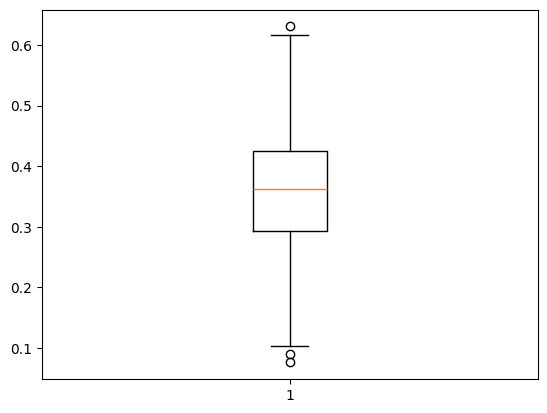

In [ ]:
# plt.hist(sis_1, bins=20)

# create a box plot of the SIS values
plt.boxplot(sis_1)


In [48]:
trainer_2.fit(mpnn2, train_loader_2, val_loader_2)
trainer_3.fit(mpnn3, train_loader_3, val_loader_3)
trainer_4.fit(mpnn4, train_loader_4, val_loader_4)
trainer_5.fit(mpnn5, train_loader_5, val_loader_5)
trainer_6.fit(mpnn6, train_loader_6, val_loader_6)
trainer_7.fit(mpnn7, train_loader_7, val_loader_7)
trainer_8.fit(mpnn8, train_loader_8, val_loader_8)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                 | Params
---------------------------------------------------------
0 | message_passing | BondMessagePassing   | 10.3 M
1 | agg             | AttentiveAggregation | 2.2 K 
2 | bn              | Identity             | 0     
3 | predictor       | RegressionFFN        | 33.0 M
  | other params    | n/a                  | 1.8 K 
---------------------------------------------------------
43.3 M    Trainable params
1.8 K     Non-trainable params
43.3 M    Total params
173.278   Total estimated model params size (MB)


Epoch 0:  12%|█▏        | 89/761 [00:05<00:42, 15.96it/s, v_num=124, train/loss=0.00677]

c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                 | Params
---------------------------------------------------------
0 | message_passing | BondMessagePassing   | 10.3 M
1 | agg             | AttentiveAggregation | 2.2 K 
2 | bn              | Identity             | 0     
3 | predictor       | RegressionFFN        | 33.0 M
  | other params    | n/a                  | 1.8 K 
---------------------------------------------------------
43.3 M    Trainable params
1.8 K     Non-trainable params
43.3 M    Total params
173.278   Total estimated model params size (MB)


Epoch 0:  26%|██▋       | 201/761 [00:12<00:34, 16.41it/s, v_num=125, train/loss=0.00586]

In [ ]:
# from chemprop import models 

# trainer_1.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn1.ckpt')
# trainer_2.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn2.ckpt')
# trainer_3.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn3.ckpt')
# trainer_4.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn4.ckpt')
# trainer_5.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn5.ckpt')
# trainer_6.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn6.ckpt')
# trainer_7.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn7.ckpt')
# trainer_8.save_checkpoint(r'C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn8.ckpt')

# checkpoint = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn1.ckpt")
# checkpoint2 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn2.ckpt")
# checkpoint3 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn3.ckpt")
# checkpoint4 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn4.ckpt")
# checkpoint5 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn5.ckpt")
# checkpoint6 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn6.ckpt")
# checkpoint7 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn7.ckpt")
# checkpoint8 = torch.load(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\mpnn8.ckpt")

# # Assuming 'output_size' needs to be added or corrected
# # You need to know the correct value for 'output_size'
# checkpoint['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint2['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint3['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint4['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint5['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint6['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint7['hyper_parameters']['agg']['output_size'] = 2200
# checkpoint8['hyper_parameters']['agg']['output_size'] = 2200

# torch.save(checkpoint, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_1.ckpt")
# torch.save(checkpoint2, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_2.ckpt")
# torch.save(checkpoint3, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_3.ckpt")
# torch.save(checkpoint4, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_4.ckpt")
# torch.save(checkpoint5, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_5.ckpt")
# torch.save(checkpoint6, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_6.ckpt")
# torch.save(checkpoint7, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_7.ckpt")
# torch.save(checkpoint8, r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_8.ckpt")



In [ ]:
trainer_1.test(mpnn1, test_loader)
trainer_2.test(mpnn2, test_loader)
trainer_3.test(mpnn3, test_loader)
trainer_4.test(mpnn4, test_loader)
trainer_5.test(mpnn5, test_loader)
trainer_6.test(mpnn6, test_loader)
trainer_7.test(mpnn7, test_loader)
trainer_8.test(mpnn8, test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.57it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09786268323659897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09854502230882645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09869420528411865
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 16/16 [00:01<00:00, 14.20it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09856154024600983
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 17.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09799440950155258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 25.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09825838357210159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 32.85it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.09853657335042953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 32.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse           0.0988086462020874
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/rmse': 0.0988086462020874}]

In [ ]:
mpnn_1_preds = trainer_1.predict(mpnn1, test_loader)
mpnn_2_preds = trainer_2.predict(mpnn2, test_loader)
mpnn_3_preds = trainer_3.predict(mpnn3, test_loader)
mpnn_4_preds = trainer_4.predict(mpnn4, test_loader)
mpnn_5_preds = trainer_5.predict(mpnn5, test_loader)
mpnn_6_preds = trainer_6.predict(mpnn6, test_loader)
mpnn_7_preds = trainer_7.predict(mpnn7, test_loader)
mpnn_8_preds = trainer_8.predict(mpnn8, test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:492: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 178.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 162.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 180.92it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 184.73it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 172.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 767/767 [00:03<00:00, 192.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 176.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 767/767 [00:04<00:00, 185.00it/s]


In [ ]:
def calculate_rmse(predicted_spectra, reference_spectra):
    if len(predicted_spectra) != len(reference_spectra):
        print(len(predicted_spectra), len(reference_spectra))
        raise ValueError("Length of predicted and reference spectra lists should be the same.")

    rmse_values = []

    for i in range(len(predicted_spectra)):
        predicted = np.array(predicted_spectra[i]).squeeze()
        reference = np.array(reference_spectra[i]).squeeze()

        if len(predicted) != len(reference):
            print(len(predicted), len(reference))
            raise ValueError(f"Length of predicted and reference spectra at index {i} should be the same.")

        mse = np.mean((predicted - reference) ** 2)
        rmse = np.sqrt(mse)
        rmse_values.append(rmse)

    return rmse_values

def calculate_sis(predicted_spectra, reference_spectra):
    if len(predicted_spectra) != len(reference_spectra):
        print(len(predicted_spectra), len(reference_spectra))
        raise ValueError("Length of predicted and reference spectra lists should be the same.")

    sis_values = []

    for i in range(len(predicted_spectra)):
        predicted = np.array(predicted_spectra[i]).squeeze()
        reference = np.array(reference_spectra[i]).squeeze()

        if len(predicted) != len(reference):
            print(len(predicted), len(reference))
            raise ValueError(f"Length of predicted and reference spectra at index {i} should be the same.")

        # Set any negative values to zero
        predicted[predicted < 0] = 0
        reference[reference < 0] = 0

        # Add a small constant to avoid taking log of zero
        epsilon = 1e-10
        predicted += epsilon
        reference += epsilon

        # Ensure the spectra are normalized
        predicted = predicted / np.sum(predicted)
        reference = reference / np.sum(reference)

        # Check for negative values
        if np.any(predicted < 0) or np.any(reference < 0):
            raise ValueError("Spectra contain negative values")

        # Check for zero values
        if np.any(predicted == 0) or np.any(reference == 0):
            raise ValueError("Spectra contain zero values")

        # Calculate the SID
        sid = np.sum(predicted * np.log(predicted / reference)) + np.sum(reference * np.log(reference / predicted))

        # Calculate the SIS
        sis = 1 / (1 + sid)
        sis_values.append(sis)

    return sis_values

# rmse = calculate_rmse(pt_model_1_preds, [test_loader.dataset[i].y for i in range(len(test_loader.dataset))])

# sis = calculate_sis(pt_model_1_preds, [test_loader.dataset[i].y for i in range(len(test_loader.dataset))])

mpnn_1_preds = [np.array(pred.float()).squeeze() for pred in mpnn_1_preds]
mpnn_2_preds = [np.array(pred.float()).squeeze() for pred in mpnn_2_preds]
mpnn_3_preds = [np.array(pred.float()).squeeze() for pred in mpnn_3_preds]
mpnn_4_preds = [np.array(pred.float()).squeeze() for pred in mpnn_4_preds]
mpnn_5_preds = [np.array(pred.float()).squeeze() for pred in mpnn_5_preds]
mpnn_6_preds = [np.array(pred.float()).squeeze() for pred in mpnn_6_preds]
mpnn_7_preds = [np.array(pred.float()).squeeze() for pred in mpnn_7_preds]
mpnn_8_preds = [np.array(pred.float()).squeeze() for pred in mpnn_8_preds]

test_spectra = [test_loader.dataset[i].y for i in range(len(test_loader.dataset))]

rmse_1 = calculate_rmse(mpnn_1_preds, test_spectra)
rmse_2 = calculate_rmse(mpnn_2_preds, test_spectra)
rmse_3 = calculate_rmse(mpnn_3_preds, test_spectra)
rmse_4 = calculate_rmse(mpnn_4_preds, test_spectra)
rmse_5 = calculate_rmse(mpnn_5_preds, test_spectra)
rmse_6 = calculate_rmse(mpnn_6_preds, test_spectra)
rmse_7 = calculate_rmse(mpnn_7_preds, test_spectra)
rmse_8 = calculate_rmse(mpnn_8_preds, test_spectra)

sis_1 = calculate_sis(mpnn_1_preds, test_spectra)
sis_2 = calculate_sis(mpnn_2_preds, test_spectra)
sis_3 = calculate_sis(mpnn_3_preds, test_spectra)
sis_4 = calculate_sis(mpnn_4_preds, test_spectra)
sis_5 = calculate_sis(mpnn_5_preds, test_spectra)
sis_6 = calculate_sis(mpnn_6_preds, test_spectra)
sis_7 = calculate_sis(mpnn_7_preds, test_spectra)
sis_8 = calculate_sis(mpnn_8_preds, test_spectra)

# no_dropout_preds = [np.array(pred).squeeze() for pred in no_dropout_preds]
# dropout_preds = [np.array(pred).squeeze() for pred in dropout_preds]


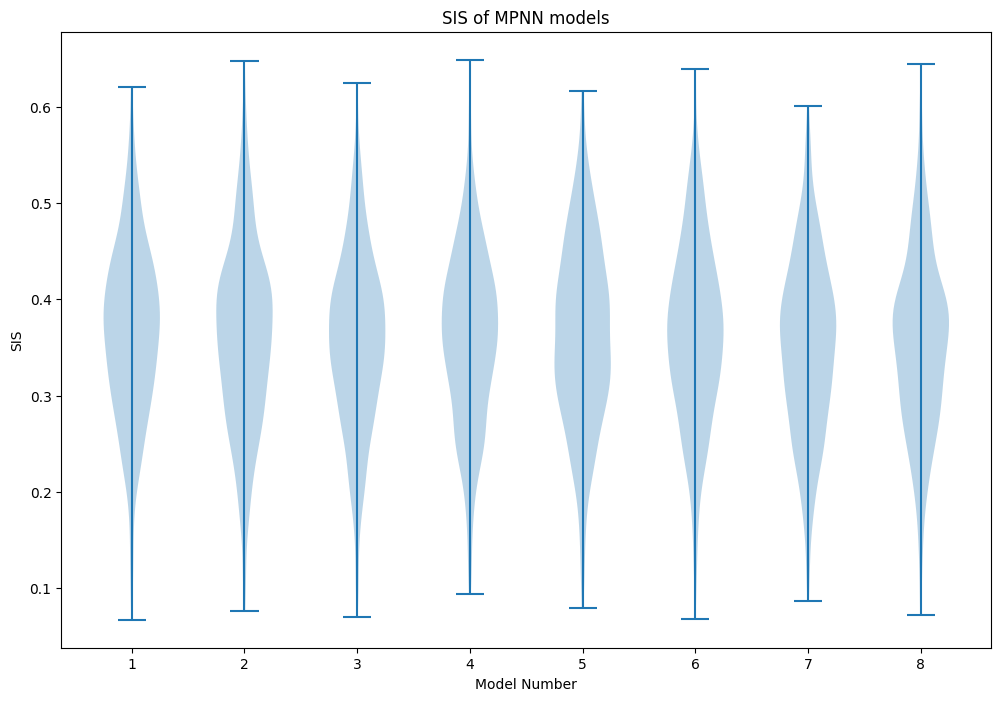

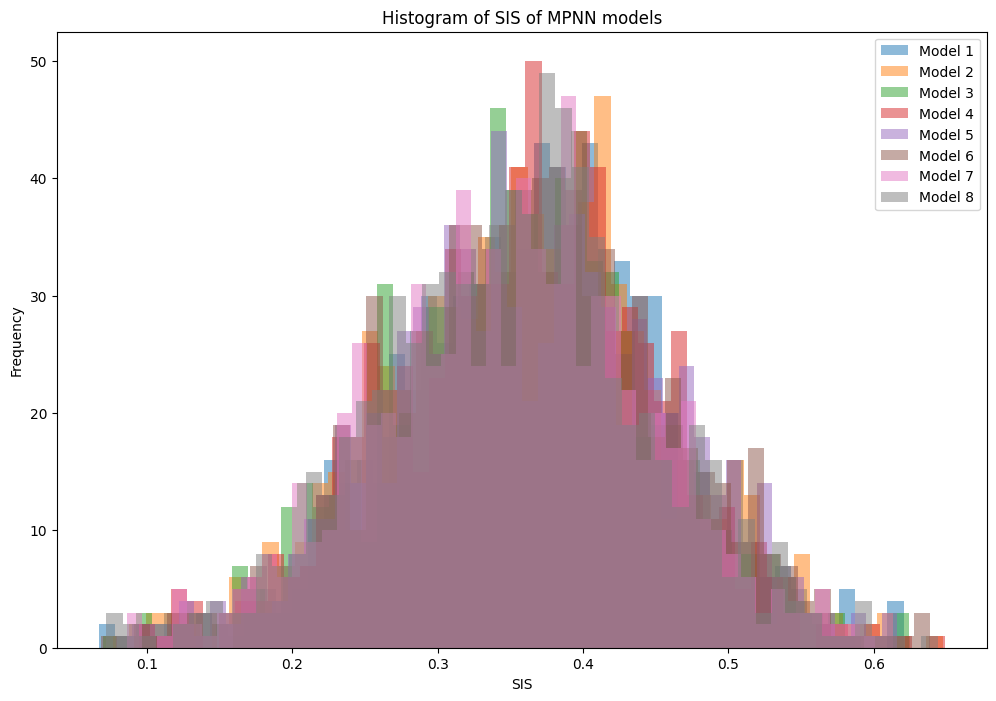

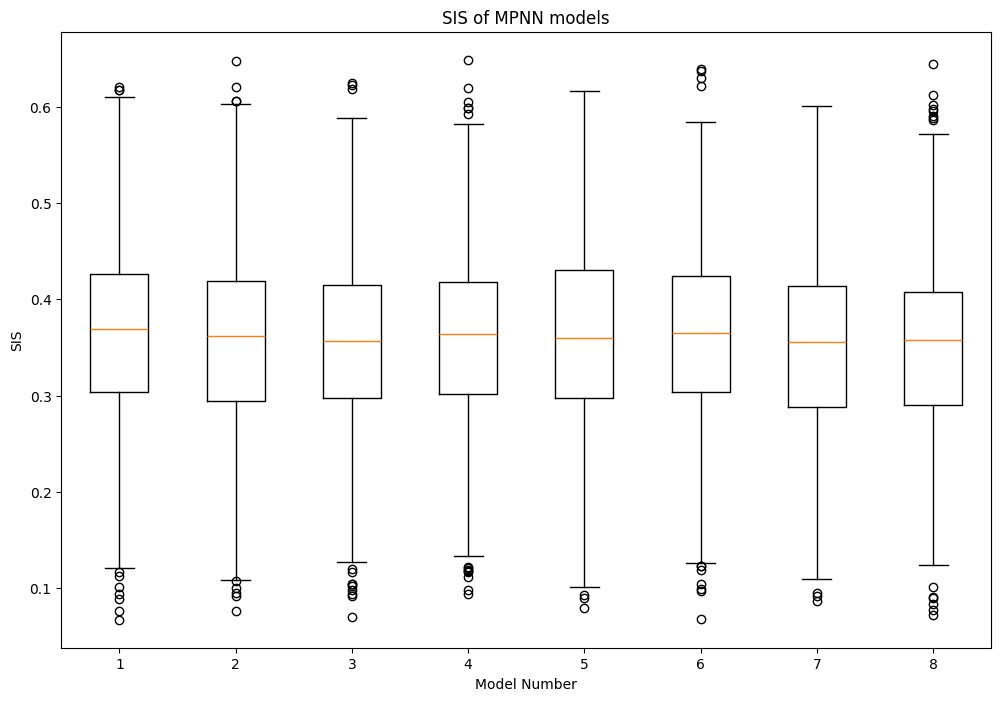

In [ ]:
# plot violin plots of SIS
plt.figure(figsize=(12, 8))
plt.violinplot([sis_1, sis_2, sis_3, sis_4, sis_5, sis_6, sis_7, sis_8])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['1', '2', '3', '4', '5', '6', '7', '8'])
plt.xlabel('Model Number')
plt.ylabel('SIS')
plt.title('SIS of MPNN models')
plt.show()

# plot histograms of SIS
plt.figure(figsize=(12, 8))
plt.hist(sis_1, bins=50, alpha=0.5, label='Model 1')
plt.hist(sis_2, bins=50, alpha=0.5, label='Model 2')
plt.hist(sis_3, bins=50, alpha=0.5, label='Model 3')
plt.hist(sis_4, bins=50, alpha=0.5, label='Model 4')
plt.hist(sis_5, bins=50, alpha=0.5, label='Model 5')
plt.hist(sis_6, bins=50, alpha=0.5, label='Model 6')
plt.hist(sis_7, bins=50, alpha=0.5, label='Model 7')
plt.hist(sis_8, bins=50, alpha=0.5, label='Model 8')

plt.xlabel('SIS')
plt.ylabel('Frequency')
plt.title('Histogram of SIS of MPNN models')
plt.legend()
plt.show()

# plot boxplots of SIS
plt.figure(figsize=(12, 8))
plt.boxplot([sis_1, sis_2, sis_3, sis_4, sis_5, sis_6, sis_7, sis_8])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['1', '2', '3', '4', '5', '6', '7', '8'])
plt.xlabel('Model Number')
plt.ylabel('SIS')
plt.title('SIS of MPNN models')
plt.show()



In [ ]:
loaded_model = models.MPNN.load_from_checkpoint(r"C:\Users\rhys-\OneDrive\Documents\Github\thesis_results\models\modified_mpnn_1.ckpt")


In [ ]:
trainer_loaded = pl.Trainer(
    precision='bf16-mixed',
    logger=True,
    enable_checkpointing=False, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=6, # number of epochs to train for
    # callbacks=[metric_tracker, early_stop_callback]
)

trainer_loaded.test(loaded_model, test_loader_1)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\rhys-\miniconda3\envs\cp3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 325/325 [00:07<00:00, 40.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/rmse          0.057879265397787094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/rmse': 0.057879265397787094}]